# End-to-end Solar Out-of-Distribution (SOoD) pipeline

This notebook presents an end-to-end training and prediction pipeline for Anomaly Detection with a standard autoencoder.

## Data Acquisition

Make sure to run the setup and install `sdo-cli` first (`make setup` and `make install`).

In [1]:
# download the dataset

!sdo-cli data download --path='./data/aia_171_2012' \
    --start='2012-01-01T00:00:00' \
    --end='2012-01-31T23:59:00' \
    --freq='12h' \
    --wavelength='171'

Starting to download images...
loading data for 62 images between 2012-01-01 00:00:00 and 2012-01-31 23:59:00


In [2]:
# resize the images to 256x256

!sdo-cli data resize --path='./data/aia_171_2012' \
    --targetpath='./data/aia_171_2012_256/train' \
    --size="256" \
    --wavelength='171'

Starting to generate resized images...
converting 62 images


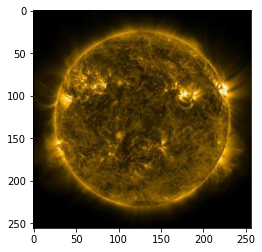

In [3]:
#inspect an image

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os 

data_dir = "./data/aia_171_2012_256/train"
aia_wave = 171
images = list(Path(data_dir).rglob(f'*__{aia_wave}.jpeg'))
img_path = images[0]

src_img = Image.open(img_path)
plt.imshow(np.asarray(src_img))

## Training

For a visual inspection of the training process start a [Visdom Server](https://github.com/fossasia/visdom): `make visdom` and change the logger to `visdom`. Head over to [http://localhost:8080](http://localhost:8080) and start the training:

In [4]:
# training a ceVAE model for the downloaded images (note that a much larger dataset should be used in practice)

output_dir = "./output/train"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

!sdo-cli sood ae train \
    --target-size=256 \
    --data-dir="./data/aia_171_2012_256" \
    -o "./output/train"\
    --logger "file" \
    --n-epochs 10


Start epoch  0
Train Epoch: 0 [0/4  (0%)] Loss: 0.004023: 4it [00:39,  9.75s/it]
====> Epoch: 0 Average loss: 0.0654
Validating: 4it [00:25,  6.40s/it]
====> Epoch: 0 Validation loss: 0.0654

Start epoch  1
Train Epoch: 1 [0/4  (0%)] Loss: 0.004067: 4it [00:39,  9.81s/it]
====> Epoch: 1 Average loss: 0.0652
Validating: 4it [00:25,  6.41s/it]
====> Epoch: 1 Validation loss: 0.0642

Start epoch  2
Train Epoch: 2 [0/4  (0%)] Loss: 0.003980: 4it [00:39,  9.94s/it]
====> Epoch: 2 Average loss: 0.0606
Validating: 4it [00:25,  6.38s/it]
====> Epoch: 2 Validation loss: 0.0475

Start epoch  3
Train Epoch: 3 [0/4  (0%)] Loss: 0.002956: 4it [00:39,  9.93s/it]
====> Epoch: 3 Average loss: 0.0382
Validating: 4it [00:25,  6.41s/it]
====> Epoch: 3 Validation loss: 0.0306

Start epoch  4
Train Epoch: 4 [0/4  (0%)] Loss: 0.001934: 4it [00:39,  9.85s/it]
====> Epoch: 4 Average loss: 0.0245
Validating: 4it [00:25,  6.38s/it]
====> Epoch: 4 Validation loss: 0.0223

Start epoch  5
Train Epoch: 5 [0/4  (0%

## Predict

In [5]:
# download a test sequence

!sdo-cli data download \
    --path='./data/aia_171_2012_full_disk_flare' \
    --start='2012-03-07T00:02:00' \
    --end='2012-03-07T00:40:00' \
    --freq='6min' \
    --wavelength='171'

!sdo-cli data resize \
    --path='./data/aia_171_2012_full_disk_flare' \
    --targetpath='./data/aia_171_2012_full_disk_flare_256/test' \
    --wavelength='171' \
    --size=256

Starting to download images...
loading data for 7 images between 2012-03-07 00:02:00 and 2012-03-07 00:40:00
Starting to generate resized images...
converting 7 images


In [6]:
import os, glob

def find_newest_dir(pattern):
    newest_dir = max(glob.glob(pattern), key=os.path.getmtime)
    print(newest_dir)
    return newest_dir

In [9]:
# pixel-level predictions

import os 

train_path = find_newest_dir('./output/train/*/')
load_path = train_path / Path('checkpoint')

pred_output_dir = "./output/pred"
if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
!sdo-cli sood ae predict \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/pred' \
    --logger "file" \
    --mode="pixel"

./output/train/20210806-154220_ae2d/
0it [00:00, ?it/s]/Users/mariusgiger/repos/master/sdo-cli/.venv/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
7it [00:06,  1.06it/s]


./output/pred/20210806-155839_ae2d/


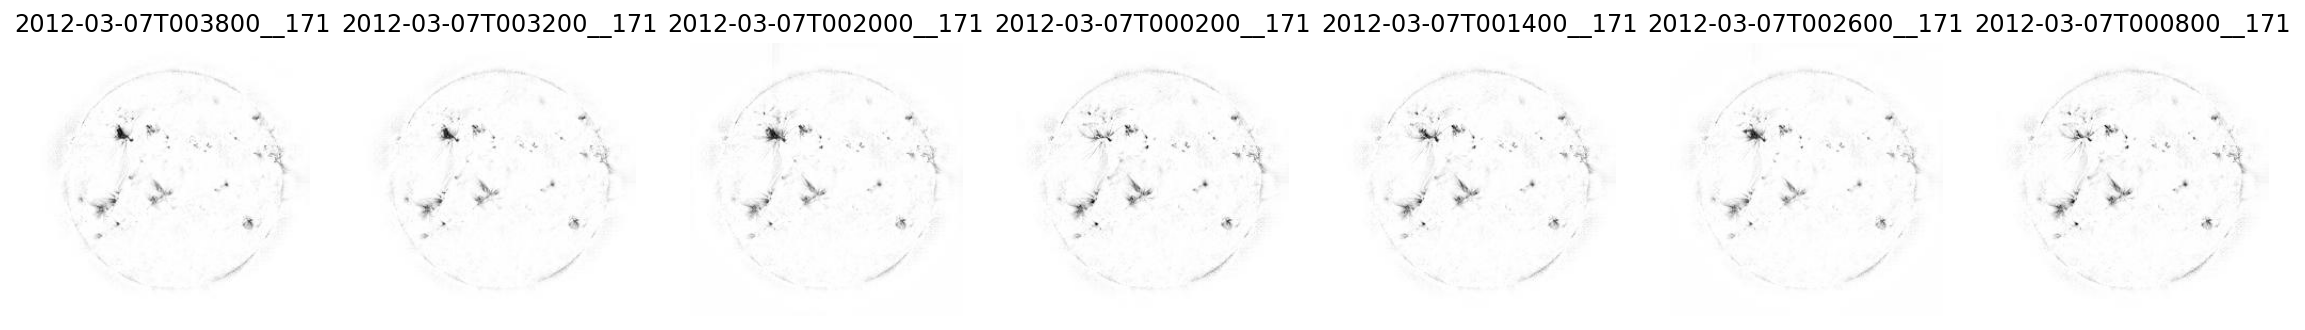

In [10]:
# display inverted pixel-wise anomaly scores

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 

aia_wave = 171
newest_dir = find_newest_dir('./output/pred/*/')
pixel_pred_path =  newest_dir / Path("predictions")
images = list(Path(pixel_pred_path).rglob(f'*__{aia_wave}.jpeg'))

f, axarr = plt.subplots(1,7, figsize=(20, 9))

row_index = 0
column_index = 0

for index, path in enumerate(images):
    img = Image.open(path)
    img_arr = np.invert(np.asarray(img))
    axarr[column_index].set_title(path.stem)
    axarr[column_index].imshow(img_arr, cmap='gray', vmin=0, vmax=255)
    axarr[column_index].spines['top'].set_visible(False)
    axarr[column_index].spines['right'].set_visible(False)
    axarr[column_index].spines['bottom'].set_visible(False)
    axarr[column_index].spines['left'].set_visible(False)
    axarr[column_index].xaxis.set_ticks([])
    axarr[column_index].yaxis.set_ticks([])

    if(column_index == 6):
        row_index = (row_index + 1)
        
    column_index = (column_index + 1) % 7

In [12]:
# sample-level predictions

!sdo-cli sood ae predict \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/pred' \
    --logger "file" \
    --mode="sample"

0it [00:00, ?it/s]/Users/mariusgiger/repos/master/sdo-cli/.venv/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
7it [00:06,  1.08it/s]


In [13]:
# investigate sample-wise scores

import pandas as pd

newest_dir = find_newest_dir('./output/pred/*/')
sample_pred_path =  newest_dir / Path("predictions/predictions.txt")

df = pd.read_csv(sample_pred_path, header=None, names = ["img", "score"])
df.head(7)

./output/pred/20210806-160036_ae2d/


,img,score
0,2012-03-07T000200__171.jpeg,0.008096
1,2012-03-07T000800__171.jpeg,0.008080
2,2012-03-07T001400__171.jpeg,0.008334
3,2012-03-07T002000__171.jpeg,0.009059
4,2012-03-07T002600__171.jpeg,0.008830
5,2012-03-07T003200__171.jpeg,0.008505
6,2012-03-07T003800__171.jpeg,0.008622


In [14]:
df.describe()

,score
count,7.000000
mean,0.008504
std,0.000366
min,0.008080
25%,0.008215
50%,0.008505
75%,0.008726
max,0.009059
